# Comparison of Kullback-Leibler divergence estimators

## Load packages

In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from typing import Literal
from sklearn.preprocessing import KBinsDiscretizer 

## Empirical CDF estimator

Proposed by [Fernando Pérez-Cruz](https://ieeexplore.ieee.org/document/4595271)

Implementation based on post by [kjetil b halvorsen](https://stats.stackexchange.com/questions/211175/kullback-leibler-divergence-for-two-samples/248657#248657)
with Run Length Encoding code by [Thomas Browne](https://stackoverflow.com/a/32681075)

In [2]:
def rle(inarray):
    """Run Length Encoding. Doesn't perform sort internally.

    Parameters
    ----------
    inarray : 1d array-like
        Array to be encoded.

    Returns
    -------
    z : np.ndarray
        Run lengths
    p : np.ndarray
        Positions
    v : np.ndarray
        Values
    """
    ia = np.asarray(inarray)  # force numpy
    n = len(ia)
    if n == 0:
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]  # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)  # must include last element posi
        z = np.diff(np.append(-1, i))  # run lengths
        p = np.cumsum(np.append(0, z))[:-1]  # positions
        return (z, p, ia[i])

In [3]:
def ecdf(X, X_min=None, X_max=None):
    """Empirical CDF (cumulative distribution funciton) from random sample.

    Continous approximation via linear interpolation.
    
    Returns function which can be used to get value of empirical CDF for any point.

    Parameters
    ----------
    X : 1d array-like
        Random sample
    X_min : float, default=None
        Left limit of the domain
    X_max : 1d array-like, default=None
        Right limit of the domain

    Returns
    -------
    cdf : function
        Empirical CDF
    """
    X = np.asarray(X, copy=True)
    n = len(X)
    X.sort()

    X_u = np.unique(X)
    # In case there are duplicates perform rle
    if n != len(X_u):
        X_rle, _, _ = rle(X)
    else:
        X_rle = np.ones_like(X)

    # Points going through middle of step function centered at points from the sample (in case duplicates stacked steps)
    y = (np.cumsum(X_rle) - 0.5 * X_rle) / n
    # Attach left and right limit for proper interpolation
    if (X_min is not None) and (X_u[0] != X_min):
        X_u = np.concatenate([[X_min], X_u])
        y = np.concatenate([[0], y])
    if (X_max is not None) and (X_u[-1] != X_max):
        X_u = np.concatenate([X_u, [X_max]])
        y = np.concatenate([y, [1]])
        
    return functools.partial(np.interp, xp=X_u, fp=y, left=0, right=1)

In [4]:
def kl_div(X, Y, eps=None, num_instab: Literal["warning", "ignore"] = "warning"):
    """Kullback-Leibler divergence (relative entropy) estimator.

    According to Perez-Cruz algorithm using empirical CDFs.

    Parameters
    ----------
    X : 1d array-like
        Random sample ("true" distribution).
    Y : 1d array-like
        Random sample ("model" distribution).
    eps : float, default=None
        epsilon for calculation of CDFs differential.
    num_instab : {'warning', 'ignore'}, default='warning'
        How to handle numerical instability caused by close to horizontal CDF of Y.

    Returns
    -------
    kl_div : float
        Estimation of Kullback-Leibler divergence.
    """
    # Force numpy array
    X = np.asarray(X, copy=True)
    Y = np.asarray(Y, copy=True)

    if eps is None:
        # Calculate epsilon two times smaller than smallest spacing between points in each random sample
        X_u = np.unique(X)
        X_u.sort()
        Y_u = np.unique(Y)
        Y_u.sort()
        dx = np.diff(X_u)
        dy = np.diff(Y_u)
        eps = np.concat([dx, dy]).min() / 2

    tot_domain = np.concat([X, Y])
    tot_min = tot_domain.min() - eps
    tot_max = tot_domain.max()

    # "Stretch" Q CDF to avoid division by zero
    P = ecdf(X)
    Q = ecdf(Y, X_min=tot_min, X_max=tot_max)

    dP = P(X) - P(X - eps)
    dQ = Q(X) - Q(X - eps)

    mask_dP = dP != 0.0
    mask_dQ = dQ != 0.0
    mask = mask_dP & mask_dQ

    # Raise warning
    if num_instab == "warning":
        if (problems := (~mask_dQ).sum()) != 0:
            print(
                f"{problems} point removed due to zeros encounter in dQ. This suggests numerical instability - return value might not be reliable. Try dividing sample in few parts and taking average result."
            )

    # Non-singular elemnts
    odds = dP[mask] / dQ[mask]
    # Include zeros of dP - since they contribute 0, we need to only modify normalization n
    n = len(odds) + (~mask_dP).sum()
    result = np.log(odds).sum() / n - 1

    # Force non-negative result
    return max(result, 0)

## knn estimator

Proposed by [Wang et al.](https://ieeexplore.ieee.org/document/4839047)

Code by [Nathan Hartland](https://github.com/nhartland/KL-divergence-estimators/tree/master)

In [5]:
def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert len(s1.shape) == len(s2.shape) == 2
    # Check dimensionality of sample is identical
    assert s1.shape[1] == s2.shape[1]
    
def scipy_estimator(s1, s2, k=1):
    """KL-Divergence estimator using scipy's KDTree
    s1: (N_1,D) Sample drawn from distribution P
    s2: (N_2,D) Sample drawn from distribution Q
    k: Number of neighbours considered (default 1)
    return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d, _ = KDTree(s2).query(s1, k)
    rho_d, _ = KDTree(s1).query(s1, k + 1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d / n) * np.sum(np.log(nu_d[::, -1] / rho_d[::, -1]))
    else:
        D += (d / n) * np.sum(np.log(nu_d / rho_d[::, -1]))

    return max(D, 0)

## Binning estimator

In [6]:
def kl_div_bin(X, Y, n_bins=10, strategy="quantile", verbose=False):
    n_x = len(X)
    n_y = len(Y)
    binner = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
    X_binned = binner.fit_transform(X)
    Y_binned = binner.transform(Y)

    result = 0
    for i in range(n_bins):
        y_count = (Y_binned == i).sum()

        if y_count == 0:
            if verbose:
                print("Empty bin for Y - value omitted")
            continue

        x_count = (X_binned == i).sum()
        
        result += x_count/n_x * np.log((x_count/n_x)/(y_count/n_y))
    return max(0,result)

## Analytic KL divergence

In [7]:
def kl_div_norm_norm(mu_1, sigma_1, mu_2, sigma_2):
    return ((mu_1 - mu_2) ** 2 + sigma_1**2 - sigma_2**2) / (
        2 * sigma_2**2
    ) + np.log(sigma_2 / sigma_1)


def kl_div_uni_uni(a_1, b_1, a_2, b_2):
    return np.log((b_2 - a_2) / (b_1 - a_1))


def kl_div_exp_exp(lambda_1, lambda_2):
    return np.log(lambda_1 / lambda_2) + lambda_2 / lambda_1 - 1

## Comparison

### Self-divergence standard normal distribution

In [8]:
mu_1 = 0
sigma_1 = 1
mu_2 = mu_1
sigma_2 = sigma_1
rng = np.random.default_rng(seed=42)
X = rng.normal(mu_1, sigma_1, 100_000)
Y = rng.normal(mu_2, sigma_2, 100_000)
print(f"Empirical CDF estimator - {kl_div(X, Y)}")
print(f"knn estimator           - {scipy_estimator(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Binning estimator       - {kl_div_bin(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Analytical result       - {kl_div_norm_norm(mu_1, sigma_1, mu_2, sigma_2)}")

Empirical CDF estimator - 0.0004567471939944667
knn estimator           - 0
Binning estimator       - 0.00011878705189443382
Analytical result       - 0.0


### Two normal distributions - $\mathcal{N}(0,1)$ and $\mathcal{N}(0,2)$

In [9]:
mu_1 = 0
sigma_1 = 1
mu_2 = 0
sigma_2 = 2
size = 100_000
rng = np.random.default_rng(seed=42)
X = rng.normal(mu_1, sigma_1, size)
Y = rng.normal(mu_2, sigma_2, size)
print(f"Empirical CDF estimator - {kl_div(X, Y)}")
print(f"knn estimator           - {scipy_estimator(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Binning estimator       - {kl_div_bin(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Analytical result       - {kl_div_norm_norm(mu_1, sigma_1, mu_2, sigma_2)}")

Empirical CDF estimator - 0.3148033341857741
knn estimator           - 0.31550281847300415
Binning estimator       - 0.23010721551018237
Analytical result       - 0.3181471805599453


### Two normal distributions - $P\sim\mathcal{N}(0,1)$ and $Q\sim\mathcal{N}(0,0.2)$

In [10]:
mu_1 = 0
sigma_1 = 1
mu_2 = 0
sigma_2 = 0.2
size = 100_000
rng = np.random.default_rng(seed=42)
X = rng.normal(mu_1, sigma_1, size)
Y = rng.normal(mu_2, sigma_2, size)
print(f"Empirical CDF estimator - {kl_div(X, Y)}")
print(f"knn estimator           - {scipy_estimator(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Binning estimator       - {kl_div_bin(X.reshape(-1,1), Y.reshape(-1,1))}")
print(f"Analytical result       - {kl_div_norm_norm(mu_1, sigma_1, mu_2, sigma_2)}")

6898 point removed due to zeros encounter in dQ. This suggests numerical instability - return value might not be reliable. Try dividing sample in few parts and taking average result.
Empirical CDF estimator - 4.146234064438398
knn estimator           - 4.207346717859741
Binning estimator       - 1.97754059004881
Analytical result       - 10.390562087565897


Warning is caused by flat regions of empirical CDF of $Q$ which have to be removed.
 
In this case all methods differ from analytical result. This is caused by regions where distributions differ significantly - even by orders of magnitude.

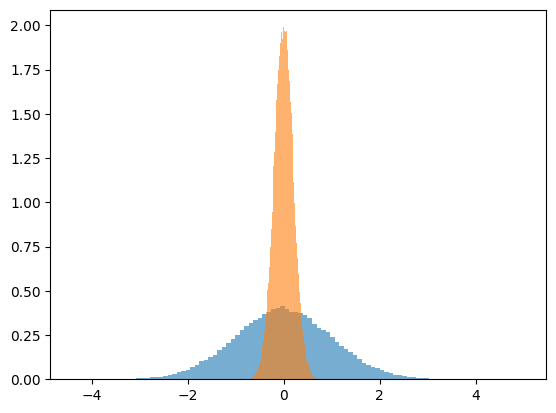

In [11]:
plt.hist(X, bins=100, density=True, alpha=0.6)
plt.hist(Y, bins=100, density=True, alpha=0.6)
# plt.hist(np.append(X,Y), bins=100, density=True, alpha=0.6)
plt.show()

In [13]:
mu_1 = 0
sigma_1 = 1
mu_2 = 0
sigma_2 = 0.2
size = 100_000
rng = np.random.default_rng(seed=42)
ecdf_kl_list = []
ecdf_kl_avg_list = []
knn_kl_list = []
bin_kl_list = []

n = 1000
n_chunks = 10
for i in range(n):
    X = rng.normal(mu_1, sigma_1, size)
    Y = rng.normal(mu_2, sigma_2, size)

    ecdf_kl_list.append(kl_div(X, Y, num_instab="ignore"))
    kl_div_loop = []
    for j in range(n_chunks):
        chunk_start = j*size//n_chunks
        chunk_end = (j+1)*size//n_chunks
        kl_div_loop.append(kl_div(X[chunk_start:chunk_end],Y[chunk_start:chunk_end], num_instab="ignore"))

    ecdf_kl_avg_list.append(np.mean(kl_div_loop))    

    knn_kl_list.append(scipy_estimator(X.reshape(-1,1), Y.reshape(-1,1)))
    bin_kl_list.append(kl_div_bin(X.reshape(-1,1), Y.reshape(-1,1)))
    print(i, flush=True, end="\r")


print("")
print(f"Empirical CDF estimator          - {np.mean(ecdf_kl_list)} +/- {np.std(ecdf_kl_list)}")
print(f"Empirical CDF estimator averaged - {np.mean(ecdf_kl_avg_list)} +/- {np.std(ecdf_kl_avg_list)}")
print(f"knn estimator                    - {np.mean(knn_kl_list)} +/- {np.std(knn_kl_list)}")
print(f"Binning estimator                - {np.mean(bin_kl_list)} +/- {np.std(bin_kl_list)}")
print(f"Analytical result                - {kl_div_norm_norm(mu_1, sigma_1, mu_2, sigma_2)}")

999
Empirical CDF estimator          - 3.951123498073733 +/- 0.4454386667139436
Empirical CDF estimator averaged - 4.146422084060579 +/- 0.03987596716105402
knn estimator                    - 4.396171911959766 +/- 0.07136277428268406
Binning estimator                - 1.6355941062122235 +/- 0.5385350060505641
Analytical result                - 10.390562087565897
